# Creating a Convolutional Neural Network Model

In [2]:
#Based on examples from the Keras documentation
import numpy as np
np.random.seed(42)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

num_classes = 5
input_shape = (136, 136, 1)

with open("/share/jcorner_data/gridrad/nexrad/nexradv2/2007_2014_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/gridrad/nexrad/nexradv2/2015_2015_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/gridrad/nexrad/nexradv2/2016_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (3364, 136, 136, 1)
3364 train samples
277 validate samples
463 test samples


In [3]:
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
gpus

2023-09-20 01:18:02.005199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 01:18:02.144336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-20 01:18:02.144522: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        #layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        #layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        #layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

2023-09-15 01:06:48.082869: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-15 01:06:48.083538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 01:06:48.083745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-15 01:06:48.083868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [ ]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

In [4]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np


def radar_norm():
    r"""Return a colormap and normalization that allow you to represent
    radar data with colors every 5 dBZ that mimics the official NWS
    radar images.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    norm: BoundaryNorm
        Normalization for 5 dBZ levels (0-80).
    """ 

    cmap = radar_colormap()
    classes = np.array(list(range(0, 85, 5)))
    norm = BoundaryNorm(classes, ncolors=cmap.N)    
    
    return cmap, norm


def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap


def draw_box_plot(ax, img, cbar_shrink=0.35):
    r"""Creates a pre-packaged display for indidivual or summary
    svrimg images.  Modifies an input axis.
    
    Parameters
    ----------
    ax: matplotlib.pyplot.axes.Axes
        Modifiable matplotlib.pyplot axis.
    img: (M, N) ndarray
        SVRIMG radar image
    cbar_shrink: numeric
        Value between 0 - 1.  This will be replacedwith kwargs in 
        future for more customization. Default is 0.35.
    Returns
    -------
    ax: matplotlib.pyplot.axes.Axes
        Modified matplotlib.pyplot axis.
    """ 

    cmap, norm = radar_norm()
    mmp = ax.imshow(np.flipud(img), cmap=cmap, norm=norm)
    ax.arrow(125.5, 119, 0, -0.0001, head_width=10, head_length=15, fc='k', ec='k', zorder=10)
    ax.text(121, 130, "N", fontsize=35, zorder=10)
    
    plt.colorbar(mmp, ax=ax, shrink=cbar_shrink, pad=0.01)
    ax.set_yticks(list(range(0, 153, 17)))
    ax.set_yticklabels([0, 64, 128, 192, 256, 320, 384, 448, 512])
    ax.set_xticks(list(range(0, 153, 17)))
    ax.set_xticklabels([0,  64, 128, 192, 256, 320, 384, 448, 512])
    ax.set_xlabel("km")
    ax.set_ylabel("km")
    ax.grid()
    
    return ax

<AxesSubplot:xlabel='km', ylabel='km'>

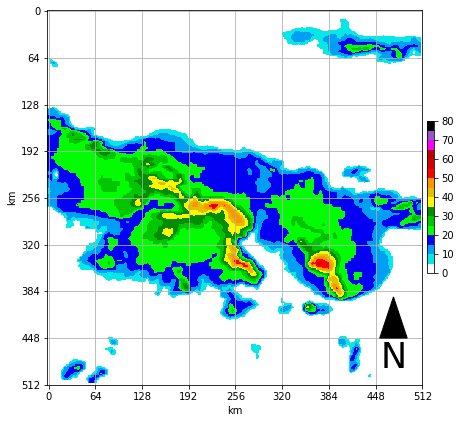

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

from matplotlib.colors import BoundaryNorm

cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

sample = x_test[102]
ax = plt.subplot(1,1,1)
draw_box_plot(ax, sample.squeeze()*80)

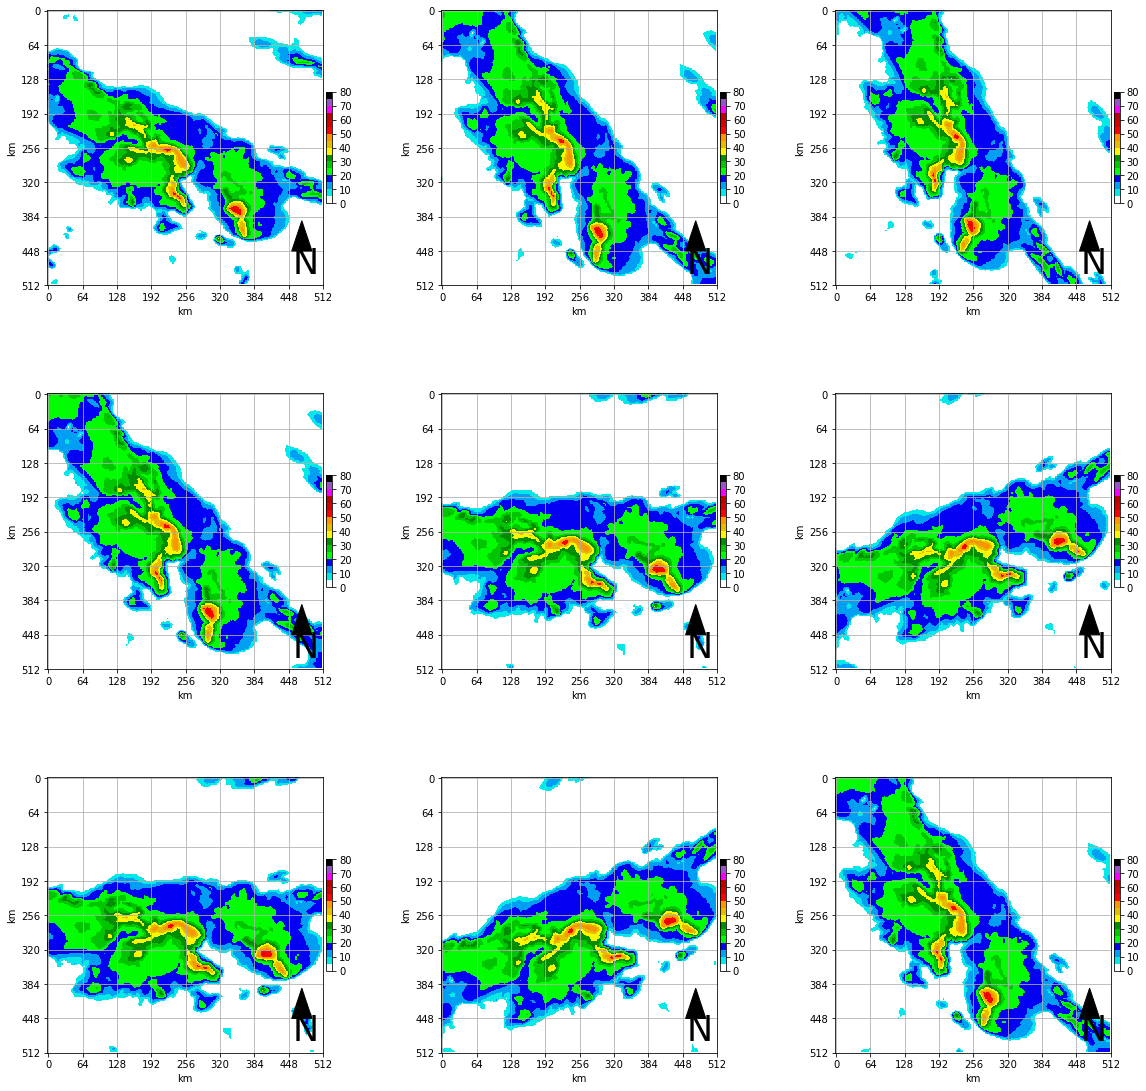

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

plt.rcParams['figure.figsize'] = 20, 20

samples = expand_dims(sample, 0)

datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

aug_imgs = datagen.flow(samples, batch_size=1)

for i in range(9):
   
    ax = plt.subplot(3,3,i+1)

    batch = aug_imgs.next()

    draw_box_plot(ax, batch[0].squeeze()*80)

In [7]:
epochs = 30

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=epochs, validation_data=(x_val, y_val), workers=8)

Epoch 1/30


2023-09-15 01:07:32.601738: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8500


  1/106 [..............................] - ETA: 3:53 - loss: 1.6164 - accuracy: 0.1562

2023-09-15 01:07:33.045193: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


106/106 [==============================] - 7s 46ms/step - loss: 1.2456 - accuracy: 0.4661 - val_loss: 0.9301 - val_accuracy: 0.6679
Epoch 2/30
106/106 [==============================] - 5s 46ms/step - loss: 1.0710 - accuracy: 0.5520 - val_loss: 0.8271 - val_accuracy: 0.7220
Epoch 3/30
106/106 [==============================] - 5s 42ms/step - loss: 0.9750 - accuracy: 0.5966 - val_loss: 0.7486 - val_accuracy: 0.7184
Epoch 4/30
106/106 [==============================] - 5s 44ms/step - loss: 0.9153 - accuracy: 0.6085 - val_loss: 0.7909 - val_accuracy: 0.7112
Epoch 5/30
106/106 [==============================] - 5s 45ms/step - loss: 0.8767 - accuracy: 0.6367 - val_loss: 0.6857 - val_accuracy: 0.7509
Epoch 6/30
106/106 [==============================] - 5s 46ms/step - loss: 0.8331 - accuracy: 0.6510 - val_loss: 0.6729 - val_accuracy: 0.7509
Epoch 7/30
106/106 [==============================] - 5s 44ms/step - loss: 0.8025 - accuracy: 0.6659 - val_loss: 0.7141 - val_accuracy: 0.7329
Epoch 8/30

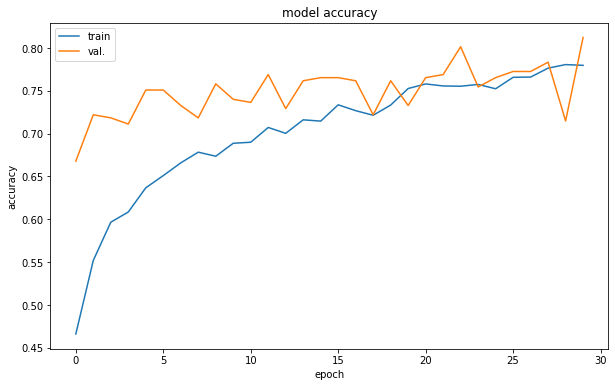

In [8]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.857055127620697
Test accuracy: 0.676025927066803


Confusion Matrix
Classification Report
                        precision    recall  f1-score   support

Disorganized and other       0.00      0.00      0.00        19
                Linear       0.76      0.78      0.77       154
             Multicell       0.55      0.62      0.58       133
              Discrete       0.75      0.75      0.75       138
              Tropical       0.47      0.42      0.44        19

              accuracy                           0.68       463
             macro avg       0.50      0.51      0.51       463
          weighted avg       0.65      0.68      0.66       463



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


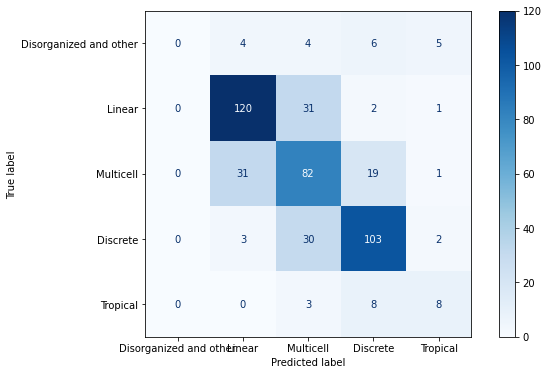

In [10]:
#create a confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

target_names = ['Disorganized and other','Linear','Multicell', 'Discrete', 'Tropical']

print('Confusion Matrix')
cm = confusion_matrix(y_test_, y_pred)
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
print('Classification Report')

print(classification_report(y_test_, y_pred, target_names=target_names))
disp.plot(cmap='Blues')

In [12]:
#save the model
model.save("/share/jcorner_data/models/Top_Class_model_v01.h5")

In [27]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Dense(16, activation="relu"),
        layers.Flatten(),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 132, 132, 32)      832       
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      51264     
                                                                 
 average_pooling2d_10 (Avera  (None, 64, 64, 64)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 60, 128)       204928    
                                                                 
 average_pooling2d_11 (Avera  (None, 30, 30, 128)      0         
 gePooling2D)                                                    
                                                                 
 dense_10 (Dense)            (None, 30, 30, 16)       

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

In [29]:
epochs = 40

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train, y_train, batch_size=128), epochs=epochs, validation_data=(x_val, y_val), workers=8)

Epoch 1/40
27/27 [==============================] - 6s 170ms/step - loss: 1.2410 - accuracy: 0.4563 - val_loss: 0.8437 - val_accuracy: 0.6318
Epoch 2/40
27/27 [==============================] - 5s 131ms/step - loss: 1.0618 - accuracy: 0.5446 - val_loss: 0.8455 - val_accuracy: 0.6606
Epoch 3/40
27/27 [==============================] - 6s 120ms/step - loss: 1.0547 - accuracy: 0.5502 - val_loss: 0.8669 - val_accuracy: 0.6715
Epoch 4/40
27/27 [==============================] - 5s 139ms/step - loss: 1.0265 - accuracy: 0.5663 - val_loss: 0.8261 - val_accuracy: 0.6679
Epoch 5/40
27/27 [==============================] - 6s 127ms/step - loss: 1.0131 - accuracy: 0.5645 - val_loss: 0.8637 - val_accuracy: 0.6462
Epoch 6/40
27/27 [==============================] - 6s 136ms/step - loss: 1.0178 - accuracy: 0.5672 - val_loss: 0.8449 - val_accuracy: 0.6859
Epoch 7/40
27/27 [==============================] - 6s 131ms/step - loss: 0.9839 - accuracy: 0.5904 - val_loss: 0.7872 - val_accuracy: 0.7148
Epoch 

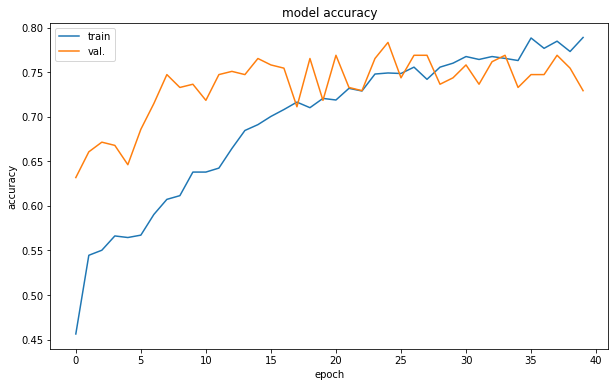

In [30]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.899257481098175
Test accuracy: 0.6263498663902283


In [26]:
#save the model
model.save("/share/jcorner_data/models/Top_Class_model_v3.h5")